In [9]:
#imports
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader, accuracy , KNNWithMeans
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NormalPredictor , BaselineOnly

plt.style.use('fast')
%matplotlib inline

In [10]:
# Read the CSV file 'music_review.csv' from the './Data/' directory into a DataFrame named 'music_review2'
music_review2 = pd.read_csv('./Data/music_review.csv')

In [11]:
music_review2.asin.nunique()

456811

In [12]:
music_review2.reviewerID.nunique()

839565

In [13]:
music_review2.isna().sum()

Unnamed: 0    0
overall       0
reviewerID    0
asin          0
reviewText    5
dtype: int64

In [14]:
# Drop the 'Unnamed: 0' column from the DataFrame 'music_review2'
music_review2 = music_review2.drop('Unnamed: 0', axis=1)

In [15]:
music_review2.dropna(inplace=True)

grouby by asin and join review text 

In [16]:
music_review2.reviewerID.value_counts()

A3W4D8XOGLWUN5    1255
AQ4B80F0JSBNI      660
A1Q0BU32CVOLRA     638
A2WQY1B8ZS7QRZ     534
A2H3JURQZOHVMB     484
                  ... 
A273QJ76P5X8W1       1
A25H4153TXX65E       1
A3HUKQ4ZPRFNTI       1
A3DQDA6Y31QO56       1
A1DZUGJ8XU0G6A       1
Name: reviewerID, Length: 839565, dtype: int64

> Let's eliminate rows with a total review and asin(song) count of one, as they are unlikely to significantly impact our model.

In [17]:
# Count the occurrences of each reviewer ID
reviewer_counts = music_review2['reviewerID'].value_counts()

# Find reviewer IDs with count equals to 1
reviewer_ids_to_drop = reviewer_counts[reviewer_counts == 1].index

# Drop rows where reviewer ID is in the list of IDs to drop
music_review2 = music_review2[~music_review2['reviewerID'].isin(reviewer_ids_to_drop)]


In [18]:
music_review2.asin.value_counts()

B00CZF8B68    1661
B00M8JCW3E     865
B00NPZI1ZS     767
B00BWGHIHY     762
B0092MKTL2     746
              ... 
B00XDI9GCE       1
B000XJ609I       1
B0054JUSDG       1
B000SZZK3O       1
B00TT8I6SW       1
Name: asin, Length: 333636, dtype: int64

In [19]:
# Count the occurrences of each reviewer ID
asin_counts = music_review2['asin'].value_counts()

# Find reviewer IDs with count equals to 1
asin_to_drop = asin_counts[asin_counts == 1].index

# Drop rows where reviewer ID is in the list of IDs to drop
music_review2 = music_review2[~music_review2['reviewerID'].isin(reviewer_ids_to_drop)]

> Given that the rating distribution is not normal, it could influence our recommendation system model. Hence, we'll generate a new normalized rating column by subtracting the average rating of each reviewID from the original rating.


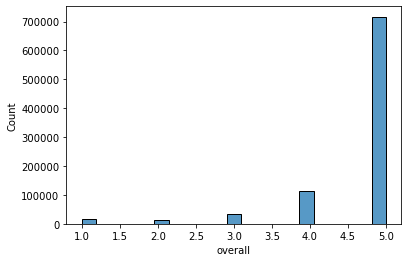

In [36]:
sns.histplot(music_review2.overall)
plt.savefig('./Images/distribution_of_rating.png')

# Show the plot
plt.show()

In [21]:
# Convert 'overall' column to integers
music_review2['overall'] = music_review2['overall'].astype(int)

# Calculate average rating for each reviewer
reviewer_avg_ratings = music_review2.groupby('reviewerID')['overall'].mean().reset_index()

# Merge the average ratings back into the DataFrame
music_review2 = music_review2.merge(reviewer_avg_ratings, on='reviewerID', suffixes=('', '_avg'))

# Subtract average rating from each rating
music_review2['normalized_rating'] = music_review2['overall'] - music_review2['overall_avg']

In [22]:
# Display the minimum and maximum values of the 'normalized_rating' column in the DataFrame 'music_review2'
music_review2.normalized_rating.min(), music_review2.normalized_rating.max()

(-3.973140495867769, 3.891891891891892)

### Function for cross-validation

>The function calculate_average_rmse serves to assess the performance of a recommendation system model by computing the average Root Mean Squared Error (RMSE) through cross-validation. It takes two main inputs: the model itself and the dataset containing music review data. Utilizing the provided model and dataset, the function conducts cross-validation, which involves splitting the data into multiple subsets, training the model on some of these subsets, and evaluating its performance on the remaining ones. 

In [23]:
def calculate_average_rmse(model, music_review):
    # Perform cross-validation
    results = cross_validate(model, music_review, measures=['RMSE'], cv=3, n_jobs=-1, verbose=True)
    
    # Average RMSE
    average_rmse = round(sum(results["test_rmse"]) / len(results["test_rmse"]), 3)
    return average_rmse

### train test split using Surprise
> As the ratings have been normalized, the rating scale is now defined as (-3.973140495867769, 3.891891891891892).Load the music review dataset into the Surprise Dataset object, selecting columns 'reviewerID', 'asin', 'normalized_rating'. 

In [24]:
# Define the rating scale for the Reader object, specifying the minimum and maximum values
reader = Reader(rating_scale=(-3.973140495867769, 3.891891891891892))

# Load the music review dataset into the Surprise Dataset object, selecting specific columns
music_review = Dataset.load_from_df(music_review2[['reviewerID', 'asin', 'normalized_rating']], reader)

# Split the dataset into training and testing sets, with a test size of 20% and a fixed random state for reproducibility
trainset, testset = train_test_split(music_review, test_size=0.2, random_state=42)


### Simple Model

#### NormalPredictor

In [25]:
# Instantiate a NormalPredictor model
NP = NormalPredictor()

# Fit the NormalPredictor model on the training set
NP.fit(trainset)

# Generate predictions for the test set based on the model fit on the training set
predictions = NP.test(testset)

# Calculate the average RMSE using cross-validation for the NormalPredictor model
average_rmse_NP = calculate_average_rmse(NP, music_review)

# Print the average RMSE obtained from cross-validation
print(f'Average RMSE from cross-validation is : {average_rmse_NP}')

Evaluating RMSE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7878  0.7874  0.7852  0.7868  0.0012  
Fit time          0.73    0.79    0.62    0.71    0.07    
Test time         2.02    1.72    1.61    1.78    0.17    
Average RMSE from cross-validation is : 0.787


### SVD

In [26]:
# Create a basic SVD model with a specified random state
svd_basic = SVD(random_state=42)

# Fit the basic SVD model to the training set
svd_basic.fit(trainset)
predictions = svd_basic.test(testset)

# Calculate the RMSE for the predictions and store it in svd_simple
svd_simple = accuracy.rmse(predictions)

# Calculate the average RMSE across all folds using the calculate_average_rmse function
average_rmse_SVD1 = calculate_average_rmse(svd_basic, music_review)
print(f'Average RMSE from cross-validation is : {average_rmse_SVD1}')

RMSE: 0.5897
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5872  0.5839  0.5816  0.5842  0.0023  
Fit time          50.36   50.24   49.79   50.13   0.25    
Test time         3.41    3.33    2.95    3.23    0.20    
Average RMSE from cross-validation is : 0.584


##### svd_basic grid search

In [27]:
# # Define a range of hyperparameters for GridSearchCV with SVD++
# param_grid = {
#     'n_factors': [50, 100, 150],  # Number of factors
#     'n_epochs': [20, 30],  # Number of epochs
#     'lr_all': [0.005, 0.01],  # Learning rate
#     'reg_all': [0.02, 0.1]  # Regularization term
# }

# # Setup GridSearchCV with SVD++
# gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# # Fit the model
# gs_svd.fit(music_review)

# # Best score and parameters
# best_rmse = gs_svd.best_score['rmse']
# best_params = gs_svd.best_params['rmse']

# print(f"Best RMSE: {best_rmse}")
# print(f"Best parameters: {best_params}")


Best RMSE: 1.0993641323939394

Best parameters: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

In [28]:
# Define a more complex SVD model with specified parameters
SVD_2 = SVD(n_factors=50, n_epochs=30, lr_all=0.01, reg_all=0.1, random_state=42)

# Fit the more complex SVD model to the training set
SVD_2.fit(trainset)
predictions = SVD_2.test(testset)

# Calculate the RMSE for the predictions and store it in svd_simple
svd_simple = accuracy.rmse(predictions)

# Calculate the average RMSE across all folds using the calculate_average_rmse function
average_rmse_SVD2 = calculate_average_rmse(SVD_2, music_review)
print(f'Average RMSE from cross-validation is : {average_rmse_SVD2}')

RMSE: 0.6198
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6114  0.6133  0.6121  0.6123  0.0008  
Fit time          44.39   44.11   44.65   44.39   0.22    
Test time         3.26    3.10    2.64    3.00    0.26    
Average RMSE from cross-validation is : 0.612


##### second SVD_3 gride search

In [29]:
# # Setup new hyperparameter dictionary
# svd_param_grid2 = {'n_factors':[5, 20],
#                   'n_epochs': [20, 40], 
#                   'lr_all': [0.05, .005],
#                   'reg_all': [0.01, 0.02]}
# svd_gr_3 = GridSearchCV(SVD,param_grid=svd_param_grid2,joblib_verbose=10, n_jobs=-1, cv=3)

# # Return best_params based on RMSE
# svd_gr_3 .fit(music_review)
# svd_gr_3 .best_params['rmse']

{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}

In [30]:
# Define SVD model with specified parameters
SVD_3 = SVD(n_factors=5, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)

# Fit the SVD model to the training set
SVD_3.fit(trainset)
predictions = SVD_3.test(testset)

# Calculate the RMSE for the predictions and store it in svd_simple_3
svd_simple_3 = accuracy.rmse(predictions)

# Calculate the average RMSE across all folds using the calculate_average_rmse function
average_rmse_SVD3 = calculate_average_rmse(SVD_3, music_review)
print(f'Average RMSE from cross-validation is : {average_rmse_SVD3}')


RMSE: 0.5871
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5819  0.5818  0.5822  0.5820  0.0002  
Fit time          14.36   14.41   14.67   14.48   0.14    
Test time         3.09    3.02    2.56    2.89    0.24    
Average RMSE from cross-validation is : 0.582


## SVD++

In [31]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_basic= SVDpp(n_factors=1, n_epochs=25, random_state=42, reg_all=0.05)
SVDpp_basic.fit(trainset)
predictions = SVDpp_basic.test(testset)
SVDpp_gs = accuracy.rmse(predictions)

RMSE: 0.6042


#### SVDpp ++ gride search

In [32]:
# param_grid = {'n_factors':[1, 5],
#                     'n_epochs':[25, 50],
#                     'reg_all':[0.02, 0.05]}

# # Setup GridSearchCV with SVD++
# gs_svdpp = GridSearchCV(SVDpp, param_grid, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)


# # Return best_params based on RMSE
# gs_svdpp .fit(music_review)
# gs_svdpp .best_params['rmse']

In [33]:
SVDpp_2= SVDpp(n_factors=5, n_epochs=25, random_state=42, reg_all=0.05)
SVDpp_2.fit(trainset)
predictions = SVDpp_2.test(testset)
SVDpp_2_gs = accuracy.rmse(predictions)

RMSE: 0.6040


## coClustering

In [34]:
from surprise import CoClustering  # Importing the CoClustering algorithm

# Define a CoClustering model with specified parameters
co_clustering = CoClustering(n_cltr_u=3, n_cltr_i=3, n_epochs=30, random_state=42)

# Fit the CoClustering model to the training set
co_clustering.fit(trainset)

# Generate predictions on the test set using the CoClustering model
predictions = co_clustering.test(testset)

# Calculate the RMSE for the predictions and store it in co_clustering_simple
co_clustering_simple = accuracy.rmse(predictions)

# Calculate the average RMSE across all folds using the calculate_average_rmse function
average_rmse_co_clustering = calculate_average_rmse(co_clustering, music_review)
print(f'Average RMSE from cross-validation is : {average_rmse_co_clustering}')


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## Model Evaluation

In [ ]:
results = {
    'NormalPredictor': average_rmse_NP,
    'svd_basic': average_rmse_SVD1,
    'SVD_2 ': average_rmse_SVD2,
    'SVD_3':average_rmse_SVD3,
    'SVDpp_basic':SVDpp_gs,
    'SVDpp_2':SVDpp_2_gs, 
    'co_clustering' : average_rmse_co_clustering,
}

In [ ]:
import matplotlib.pyplot as plt

# Sort results based on values
sorted_results = dict(sorted(results.items(), key=lambda item: item[1]))

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#c7dfeb', '#494373', '#9ebbd7', '#7d92bf', '#a6cee3', '#1f78b4', '#33a02c']

plt.bar(sorted_results.keys(), sorted_results.values(), color=colors)

plt.xlabel('Models')
plt.ylabel('Cross-validation Score')
plt.title('Cross-validation Score Comparison for Different Models')
plt.xticks(rotation=45, ha="right")

plt.show()


## Recommendation function 

#### pickle
> pickel the best model

In [ ]:
# Using Surprise, a full trainset incorporating all data can be built
trainset_full = music_review.build_full_trainset()

# Fit the SVD3 model to the full trainset to make full predictions
SVD_3.fit(trainset_full)


In [ ]:
model_filename = 'SVD3.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(SVD_3, file)

In [ ]:
music_meta = pd.read_csv('./Data/music_meta.csv')
music_meta.drop(columns =['Unnamed: 0'], inplace=True)

In [ ]:
music_meta.head()

In [ ]:
music_review_fun=music_review2.set_index('reviewerID')
music_review_fun.drop(columns=['overall', 'reviewText', 'overall_avg', 'normalized_rating'], inplace=True)
music_review_fun.head()

>The get_recommendations2 function aims to provide personalized recommendations for a given user based on their past reviews and predicted ratings. which  allows users to receive tailored recommendations based on their historical reviews and predicted preferences, thereby enhancing their overall experience with the music recommendation system.

In [ ]:
def get_recommendations3(user_id, num_recommendations):
    try:
        have_reviewed = list(music_review_fun.loc[user_id, 'asin'])
    except KeyError:
        return "User ID not found or user hasn't reviewed any items."

    not_reviewed = music_meta[~music_meta['asin'].isin(have_reviewed)].copy()
    not_reviewed.reset_index(inplace=True)

    if not_reviewed.empty:
        return "All items have been reviewed by the user."

    # Use loc to avoid SettingWithCopyWarning
    not_reviewed.loc[:, 'est_rating'] = not_reviewed['asin'].apply(lambda x: SVD_3.predict(user_id, x).est)
    not_reviewed.sort_values(by='est_rating', ascending=False, inplace=True)

    # Get top n recommendations
    recommendations = not_reviewed.head(num_recommendations)

    return recommendations

# Example usage:
user = input('UserId: ')
n_recs = int(input('How many recommendations? '))
recommendations = get_recommendations2(user, n_recs)
recommendations
